In [1]:
import os
import time
from collections import defaultdict
import six

import logging as log
import glob
import re

from matplotlib import colors, cm
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.colors import LogNorm

import numpy as np

import pandas as pd
import xarray as xr

from sqlite3 import dbapi2 as sql

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.spatial import proj_utils 
from stompy.plot import plot_wkb
from stompy.model import data_comparison
import stompy.plot.cmap as scmap

import postprocess_v00 as post

%matplotlib notebook

In [2]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')

In [3]:
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

In [4]:
import sql_common
six.moves.reload_module(sql_common)


# try to run everything that can be cached and re-used through
# here. 
PtmSet=sql_common.PtmSetNew

In [5]:
#dbs=glob.glob("/opt2/sfb_ocean/ptm/all_source_021b/*/ptm_and_grid.db")
#dbs.sort()
#ptm_set_old=sql_common.PtmSet(databases=dbs)

# Updated 2019-12-02
dbs=glob.glob("/opt2/sfb_ocean/ptm/all_source_021b/20*/ptm_and_grid.db")
dbs.sort()
ptm_set=sql_common.PtmSetNew(databases=dbs,z_thickness=0.095)

In [6]:
smooth=0
max_age=2
layer='bed'
loads='nofiber'
t_start=np.datetime64('2017-08-30')
t_stop=t_start+np.timedelta64(15,'D')

dss=[]

for ps in [ptm_set]:
    ds=ps.conc_query(t_start=t_start,
                     t_stop =t_stop,
                     z_filter=layer,
                     # grp_filter='and '
                     max_age=np.timedelta64(max_age,'D'))

    if smooth:
        ds['conc_raw']=ds.conc
        ds['conc'].values[:]=ptm_set.smooth(ds.conc_raw.values)
    dss.append(ds)

        

FileNotFoundError: [Errno 2] No such file or directory: '/opt2/sfb_ocean/ptm/all_source_020b/Alameda_Creek/20170720/FISH_PTM_hydrodynamics.inp'

In [6]:
class BayConcFigure(object):
    figsize=(8.4,8)
    ax=None
    fig=None
    vmin=1e-4
    vmax=100.0
    zoom=(517521., 609000., 4139744., 4230000.)
    cmap=cmap
    cax_loc=[0.7,0.25,0.03,0.35]
    txt_loc=[0.65,0.7] # in ax coords
    cbar_label="Particles/m$^2$"
    cbar_args={} # don't modify - replace.
    draw_boundary=True
    fontsize=14
    extra_text=[]
    grid=None
    grid_poly=None
    num=None
    
    def __init__(self,ds,**kw):
        utils.set_keywords(self,kw)
        self.ds=ds
        if self.grid is None:
            self.grid=unstructured_grid.UnstructuredGrid.from_ugrid(ds)
        if self.grid_poly is None:
            self.grid_poly=self.grid.boundary_polygon()
            
        conc=self.ds['conc'].values

        if self.fig is None:
            self.fig=plt.figure(figsize=self.figsize,num=self.num)
        if self.ax is None:
            self.ax=self.fig.add_subplot(1,1,1)
        
        self.ccoll=self.grid.plot_cells(values=conc.clip(self.vmin,self.vmax),
                                        cmap=self.cmap,norm=colors.LogNorm(vmin=self.vmin,vmax=self.vmax),
                                        edgecolor='face',lw=0.4,ax=self.ax)
        if self.draw_boundary:
            self.boundary=plot_wkb.plot_wkb(self.grid_poly,ax=self.ax,ec='k',lw=0.5,fc='none')
        if self.cax_loc is not None:
            self.cax=self.fig.add_axes(self.cax_loc) # Need refactor
            plt.colorbar(self.ccoll,cax=self.cax,label=self.cbar_label,extend='both',
                         **self.cbar_args)
        self.ax.axis('equal')
        self.ax.axis(self.zoom)
        self.ax.xaxis.set_visible(0)
        self.ax.yaxis.set_visible(0)
        self.fig.subplots_adjust(left=0.01,right=0.99,top=0.99,bottom=0.01)
        
        self.add_labels()
        
    def __del__(self):
        try:
            self.ds.close()
        except AttributeError:
            pass
    def add_labels(self):
        texts=self.behavior_label()
        texts+=self.average_label()
        texts+=self.date_label()
        texts+=self.age_label()
        texts+=self.extra_text
        self.ax.text(self.txt_loc[0],self.txt_loc[1],"\n".join(texts),
                     fontsize=self.fontsize,va='top',ha='left',transform=self.ax.transAxes)
    def behavior_label(self):
        # go from a list of groups to a label
        grp_filter=self.ds.conc.attrs['grp_filter']
        if grp_filter not in ["","none"]:
            return [self.ds.conc.attrs['grp_filter']]
        else:
            return []
        #if behavior=='none':
        #    label='Passive'
        #elif behavior.startswith('up'):
        #    w_mmps=float(behavior.replace('up',''))/1000.0
        #    label=f'Rise {w_mmps:.1f} mm/s'
        #elif behavior.startswith('down'):
        #    w_mmps=float(behavior.replace('down',''))/1000.0
        #    label=f'Settle {w_mmps:.1f} mm/s'
    def age_label(self):
        return [ 
            "Max age: %d days"%(self.ds.conc.attrs['max_age']/np.timedelta64(1,'D')) 
             ]    
    def date_label(self):
        return [self.date_label_ext(self.ds)]
    @classmethod
    def date_label_ext(cls,ds):
        t_start=ds.conc.attrs['t_start']
        t_stop =ds.conc.attrs['t_stop']
        
        def fmt_t(t): return utils.to_datetime(t).strftime('%Y-%m-%d')
        return f"{fmt_t(t_start)} – {fmt_t(t_stop)}"
    
    def average_label(self):
        return [self.average_label_ext(self.ds)]
    
    @classmethod
    def average_label_ext(cls,ds):
        if ds.conc.attrs['z_filter']=='bed':
            return "Near bed"
        elif ds.conc.attrs['z_filter']=='surf':
            return "Near surface"
        elif ds.conc.attrs['z_filter']=='all':
            return "Full depth"
        else:
            return "Vertical range: %s"%(ds.conc.attrs['z_filter'])

# Same idea but settings for coastal region.
# note that with the 15 day output, these get truncated
# and show little action in the ocean.
class CoastalConcFigure(BayConcFigure):
    figsize=(7,8.1)
    zoom=(345000., 613202., 4050000., 4230105.)
    cax_loc=[0.05,0.20,0.03,0.35]
    txt_loc=[0.05,0.13] # in ax coords
    

In [15]:
if len(dss)>1:
    ratio=dss[1].conc.values.clip(1e-4) / dss[0].conc.values.clip(1e-4)

    fig,ax=plt.subplots()
    coll=ptm_set.grid().plot_cells(values=ratio,ax=ax,cmap='jet',clim=[0.3,1])
    plt.colorbar(coll)
    ax.axis('off')
    ax.axis('equal')
    ax.axis(BayConcFigure.zoom)

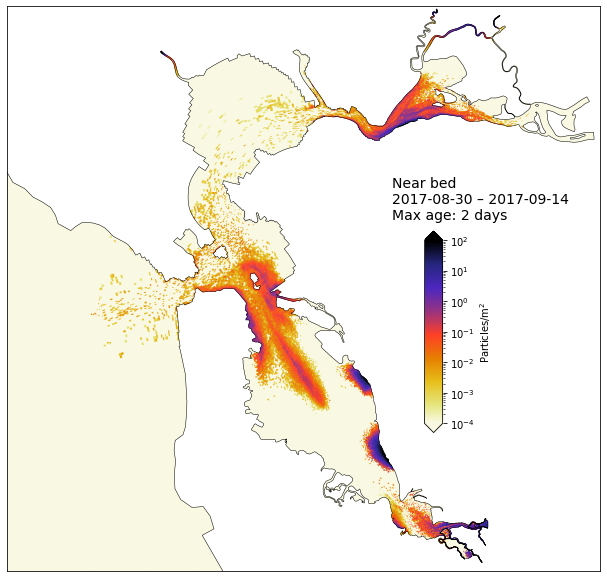

In [16]:
BayConcFigure(dss[0],grid=ptm_set.grid(),grid_poly=ptm_set.poly())

In [7]:
fig_dir="/opt2/sfb_ocean/ptm/all_source_021b/figs20200216"

In [10]:
# These plots roughly duplicate what went into the report
display=False
force=False
if not display: plt.ioff()

fig_subdir=os.path.join(fig_dir,'conc-15days')

for smooth in [0]:
    # HERE - rerun to get 15 and 20.
    # data beyond 20 is not necessarily correct!
    for max_age in [30]: # 2,5,10,18,30,15,20]:
        fig_subdir=os.path.join(fig_dir,f'conc-{max_age}days')
        for layer in ['bed']: # ['surf','bed']:
            for loads in ['nofiber','std']:
                for t_start in [# np.datetime64('2017-08-30'),
                                np.datetime64('2018-03-02'),
                                # np.datetime64('2018-03-30')
                               ]:
                    t_stop=t_start+np.timedelta64(15,'D')
                    ds=ptm_set.conc_query(t_start=t_start,
                                          t_stop=t_stop,
                                          z_filter=layer,
                                          loads=loads,
                                          max_age=np.timedelta64(max_age,'D'))
                    if smooth:
                        ds['conc_raw']=ds.conc
                        ds['conc'].values[:]=ptm_set.smooth(ds.conc_raw.values)
                        smooth_name=f"smooth{smooth}"
                    else:
                        smooth_name="raw"
                    for config in ['bay','coast']:
                        img_fn=os.path.join( fig_subdir,
                                             str(t_start),
                                             f"{layer}-{loads}-{config}-{smooth_name}.png")

                        if (not display) and os.path.exists(img_fn) and not force: 
                            log.info(f"{img_fn}: exists")
                            continue
                        log.info(f"{img_fn}: processing")

                        if config=='bay':
                            bf=BayConcFigure(ds)
                        elif config=='coast':
                            bf=CoastalConcFigure(ds)
                        else:
                            raise Exception(f"Bad config {config}")
                        if display:
                            break
                        os.makedirs(os.path.dirname(img_fn),exist_ok=True)
                        bf.fig.savefig(img_fn,dpi=200)
                        plt.close(bf.fig)
                    if display:
                        break
                if display:
                    break
            if display: 
                break
        if display:
            break
    if display:
        break
if not display: plt.ion()
                

Trying: /opt2/sfb_ocean/ptm/all_source_021b/20170720/ptm_and_grid.db
Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, particle as p, ptm_release as rel, 
                 ptm_group as grp, load.nofiber as load
            where loc.time>=1519948800 and loc.time < 1521244800
              and loc.particle_id=p.id
              and p.release_id=rel.id
              and rel.group_id=grp.id
              and grp.name=load.group_name 
              and loc.cell>=0
              and (loc.time-rel.time)<2592000
              and loc.z_from_bed<0.095
              
            group by loc.cell
DB:  /opt2/sfb_ocean/ptm/all_source_021b/20170720/ptm_and_grid.db
Query time to return data 0.00s
Trying: /opt2/sfb_ocean/ptm/all_source_021b/20170730/ptm_and_grid.db
Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, particle as p, ptm_release as rel, 
  

Trying: /opt2/sfb_ocean/ptm/all_source_021b/20171117/ptm_and_grid.db
Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, particle as p, ptm_release as rel, 
                 ptm_group as grp, load.nofiber as load
            where loc.time>=1519948800 and loc.time < 1521244800
              and loc.particle_id=p.id
              and p.release_id=rel.id
              and rel.group_id=grp.id
              and grp.name=load.group_name 
              and loc.cell>=0
              and (loc.time-rel.time)<2592000
              and loc.z_from_bed<0.095
              
            group by loc.cell
DB:  /opt2/sfb_ocean/ptm/all_source_021b/20171117/ptm_and_grid.db
Query time to return data 0.04s
Trying: /opt2/sfb_ocean/ptm/all_source_021b/20171127/ptm_and_grid.db
Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, particle as p, ptm_release as rel, 
  

Query time to return data 134.77s
Trying: /opt2/sfb_ocean/ptm/all_source_021b/20180307/ptm_and_grid.db
Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, particle as p, ptm_release as rel, 
                 ptm_group as grp, load.nofiber as load
            where loc.time>=1519948800 and loc.time < 1521244800
              and loc.particle_id=p.id
              and p.release_id=rel.id
              and rel.group_id=grp.id
              and grp.name=load.group_name 
              and loc.cell>=0
              and (loc.time-rel.time)<2592000
              and loc.z_from_bed<0.095
              
            group by loc.cell
DB:  /opt2/sfb_ocean/ptm/all_source_021b/20180307/ptm_and_grid.db
Query time to return data 63.63s
Trying: /opt2/sfb_ocean/ptm/all_source_021b/20180317/ptm_and_grid.db
Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, par

INFO:root:/opt2/sfb_ocean/ptm/all_source_021b/figs20200216/conc-30days/2018-03-02/bed-nofiber-bay-raw.png: processing


Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, particle as p, ptm_release as rel, 
                 ptm_group as grp, load.nofiber as load
            where loc.time>=1519948800 and loc.time < 1521244800
              and loc.particle_id=p.id
              and p.release_id=rel.id
              and rel.group_id=grp.id
              and grp.name=load.group_name 
              and loc.cell>=0
              and (loc.time-rel.time)<2592000
              and loc.z_from_bed<0.095
              
            group by loc.cell
DB:  /opt2/sfb_ocean/ptm/all_source_021b/20180416/ptm_and_grid.db
Query time to return data 0.00s


INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors
INFO:root:/opt2/sfb_ocean/ptm/all_source_021b/figs20200216/conc-30days/2018-03-02/bed-nofiber-coast-raw.png: processing
INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors


Trying: /opt2/sfb_ocean/ptm/all_source_021b/20170720/ptm_and_grid.db
Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, particle as p, ptm_release as rel, 
                 ptm_group as grp, load.std as load
            where loc.time>=1519948800 and loc.time < 1521244800
              and loc.particle_id=p.id
              and p.release_id=rel.id
              and rel.group_id=grp.id
              and grp.name=load.group_name 
              and loc.cell>=0
              and (loc.time-rel.time)<2592000
              and loc.z_from_bed<0.095
              
            group by loc.cell
DB:  /opt2/sfb_ocean/ptm/all_source_021b/20170720/ptm_and_grid.db
Query time to return data 0.00s
Trying: /opt2/sfb_ocean/ptm/all_source_021b/20170730/ptm_and_grid.db
Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, particle as p, ptm_release as rel, 
      

Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, particle as p, ptm_release as rel, 
                 ptm_group as grp, load.std as load
            where loc.time>=1519948800 and loc.time < 1521244800
              and loc.particle_id=p.id
              and p.release_id=rel.id
              and rel.group_id=grp.id
              and grp.name=load.group_name 
              and loc.cell>=0
              and (loc.time-rel.time)<2592000
              and loc.z_from_bed<0.095
              
            group by loc.cell
DB:  /opt2/sfb_ocean/ptm/all_source_021b/20171107/ptm_and_grid.db
Query time to return data 0.00s
Trying: /opt2/sfb_ocean/ptm/all_source_021b/20171117/ptm_and_grid.db
Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, particle as p, ptm_release as rel, 
                 ptm_group as grp, load.std as load
            where loc.t

Query time to return data 183.00s
Trying: /opt2/sfb_ocean/ptm/all_source_021b/20180225/ptm_and_grid.db
Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, particle as p, ptm_release as rel, 
                 ptm_group as grp, load.std as load
            where loc.time>=1519948800 and loc.time < 1521244800
              and loc.particle_id=p.id
              and p.release_id=rel.id
              and rel.group_id=grp.id
              and grp.name=load.group_name 
              and loc.cell>=0
              and (loc.time-rel.time)<2592000
              and loc.z_from_bed<0.095
              
            group by loc.cell
DB:  /opt2/sfb_ocean/ptm/all_source_021b/20180225/ptm_and_grid.db
Query time to return data 172.73s
Trying: /opt2/sfb_ocean/ptm/all_source_021b/20180307/ptm_and_grid.db
Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, partic

INFO:root:/opt2/sfb_ocean/ptm/all_source_021b/figs20200216/conc-30days/2018-03-02/bed-std-bay-raw.png: processing


Query

           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, particle as p, ptm_release as rel, 
                 ptm_group as grp, load.std as load
            where loc.time>=1519948800 and loc.time < 1521244800
              and loc.particle_id=p.id
              and p.release_id=rel.id
              and rel.group_id=grp.id
              and grp.name=load.group_name 
              and loc.cell>=0
              and (loc.time-rel.time)<2592000
              and loc.z_from_bed<0.095
              
            group by loc.cell
DB:  /opt2/sfb_ocean/ptm/all_source_021b/20180416/ptm_and_grid.db
Query time to return data 0.00s


INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors
INFO:root:/opt2/sfb_ocean/ptm/all_source_021b/figs20200216/conc-30days/2018-03-02/bed-std-coast-raw.png: processing
INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors


In [ ]:
# Comparison plots for the same period, depth-averaged, 
# different settling velocities.
# HERE - but maybe won't get into it.

In [ ]:
class MissingFiles(Exception): pass

class WsPanels(object):
    all_w_s=["-0.05","-0.005","-0.0005",
             "0.0",
             "0.0005","0.005","0.05"]
    figsize=(8.4,8)
    num=None
    PlotClass=BayConcFigure
    shape=(3,3)
    # weird python rules - tries to make this an instance method.
    panel_labeler=staticmethod(lambda i: "abcdefghijkl"[i])
    # for text label in each panel
    panel_txt_loc=[0.45,0.73]
    
    def loader(self,ptm_conc):
        return load_ptm_conc(ptm_conc)
    
    @classmethod
    def expand_ptm_conc(cls,ptm0_conc):
        ptm_concs=[ptm0_conc.replace("/0.0/","/"+w_s+"/")
                   for w_s in cls.all_w_s]
        if not all([os.path.exists(fn) for fn in ptm_concs]):
            log.warning("{ptm_conc} did not have all w_s - skip")
            raise MissingFiles()
        return ptm_concs
    
    def __init__(self,ptm0_conc,**kw):
        """
        ptm0_conc: path to the w_s=0.0 netcdf file.
        assumes that /0.0/ appears in the path, and
        can be replaced by the other settling velocities
        """
        utils.set_keywords(self,kw)
        
        ptm_concs=self.expand_ptm_conc(ptm0_conc)
        
        if self.num is not None:
            fig=plt.figure(figsize=self.figsize,num=self.num)
            fig.clf()
            fig.set_size_inches(self.figsize,forward=True)            
        self.fig,self.axs=plt.subplots(self.shape[0],self.shape[1],
                                       num=self.num,figsize=self.figsize)
        
        self.bfs=[]
        sum_conc=0.0
        for w_s,ptm_conc,ax in zip(self.all_w_s+['sum'],
                                   ptm_concs+['sum'],
                                   self.axs.ravel()):
            kw={}
            # Monkeys!
            kw['average_label']=lambda: ""
            kw['date_label']=lambda: ""
            if ptm_conc!=ptm_concs[0]:
                kw['cax_loc']=None
            else:
                # kw['cax_loc']=[0.68,0.03,0.02,0.28]
                kw['cax_loc']=[0.68,0.13,0.30,0.02]
                kw['cbar_args']={'orientation':'horizontal'}
            kw['txt_loc']=self.panel_txt_loc
            kw['fontsize']=12

            if ptm_conc=='sum':
                conc=sum_conc
                kw['behavior_label']=lambda: "Sum"
            else:
                ds,conc=self.loader(ptm_conc)
                sum_conc = sum_conc + conc
            bf=self.PlotClass(ds,conc=conc,ax=ax,fig=self.fig,**kw)
            self.bfs.append(bf)
            
        self.fig.subplots_adjust(hspace=0.0,wspace=0.0)
        ax=self.axs.ravel()[-1]
        plt.setp(ax.spines.values(),visible=0)
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)
        
        sum_txts=[bf.date_label_ext(bf.ds),
                  bf.average_label_ext(bf.ds)]
        ax.text(0.10,0.90,"\n".join(sum_txts),transform=ax.transAxes,
               va='top',fontsize=12)
        # This is to avoid overwriting the neighboring spines.
        ax.patch.set_facecolor('none')
        
        if self.panel_labeler is not None:
            self.label_panels(self.axs.ravel()[:8])
    panel_label_loc=[0.05,0.9]
    panel_label_kw={'va':'top','fontsize':12,'fontweight':'bold'}
    def label_panels(self,axs):
        for i,ax in enumerate(axs):
            txt=self.panel_labeler(i)
            ax.text(self.panel_label_loc[0],self.panel_label_loc[1],txt,
                    transform=ax.transAxes,**self.panel_label_kw)
        
class WsPanelsCoastal(WsPanels):
    panel_label_loc=[0.02,0.16]
    panel_txt_loc=[0.02,0.08]
    PlotClass=CoastalConcFigure

In [ ]:
# Plot a sum, surface plot vs. the manta
manta_std=pd.read_csv('manta_summary-v01std.csv')
manta_nofiber=pd.read_csv('manta_summary-v01nofiber.csv')

split_fields=('SampleID','part_per_m2','part_per_m3','area_m2')
common_fields=('SampleID','SampleType','x','y','Season')
manta_combined=pd.merge(manta_std.loc[:, split_fields],
                        manta_nofiber.loc[:, split_fields],
                        left_on='SampleID',right_on='SampleID',
                        how='outer',suffixes=['_std','_nofiber'])
manta=pd.merge(manta_nofiber.loc[:,common_fields],
               manta_combined,
               left_on='SampleID',right_on='SampleID',how='outer')

assert np.all(np.where( ~( manta['area_m2_std'].isnull() | manta['area_m2_nofiber'].isnull()),
                        manta['area_m2_std']==manta['area_m2_nofiber'],
                        True))

area=np.where(manta['area_m2_std'].isnull(),
              manta['area_m2_nofiber'],
              manta['area_m2_std'])
manta['area_m2']=area
manta.head()

In [ ]:
manta_nofiber[ np.isnan(manta.x)]

In [ ]:
manta.loc[:, ['SampleID','area_m2'] ]

In [ ]:
def scatter_and_skill(manta_good,conc_field,model_conc,fig_prefix=None):
    model_matches=[]
    for idx,rec in manta_good.iterrows():
        if np.isnan(rec['x']):
            c=-1
            print("Sample is missing coordinates")
            model_matches.append(np.nan)
        else:
            c=grid.select_cells_nearest( [rec['x'],rec['y']])
            model_matches.append(conc[c])
    manta_good=manta_good.copy()
    manta_good['model_conc']=model_matches
    manta_good=manta_good[ np.isfinite(manta_good.model_conc.values)]

    ds=xr.Dataset.from_dataframe(manta_good)

    metrics=data_comparison.calc_metrics(ds.model_conc,ds[conc_field])

    fig=plt.figure(figsize=(6,5))
    ax=fig.add_subplot(1,1,1)

    ax.loglog(manta_good[conc_field],
              manta_good['model_conc'],'g.')
    ax.set_xlabel('Observed (particles m$^{-2}$)')
    ax.set_ylabel('Predicted (particles m$^{-2}$)')

    for k in metrics:
        print(f"{k:15}: {metrics[k]: .4g}")
        
    if fig_prefix is not None:
        img_fn=fig_prefix+"-scatter.png"
        fig.savefig(img_fn)
        with open(fig_prefix+"-scatter.txt",'wt') as fp:
            for k in metrics:
                fp.write(f"{k:15}: {metrics[k]: .4g}\n")
            

In [ ]:
# So I want a sum concentration representative of wet weather.
# either 2/28 or 3/02.
# how the 2/28, 44 dayer.
display=False
force=True

for sub_version in ['std','nofiber']:
    print(f"sub_version={sub_version}")
    for max_age in [15,44]:
        print(f"max_age={max_age}")
        for season in ['Wet','Dry']:
            print(f"season={season}")
            # find the base ptm_conc
            kw={}
            if max_age==44:
                fns=combined_fns()
                loader=load_combined
                kw['extra_text']=['44 day cutoff']
            elif max_age==15:
                fns=single_fns()
                loader=load_ptm_conc
            else:
                raise Exception(f"Wha kind of max age is {max_age}")

            hit=False # did we find a good ptm_concA filename?
            for ptm_concA in fns:
                if "/0.0/" not in ptm_concA:
                    continue
                if sub_version not in ptm_concA:
                    continue
                if base_ver=='v07':
                    if ( (season=='Wet') and 
                         ('20180228' not in ptm_concA) and
                         ('20180302' not in ptm_concA) ):
                        continue
                    if ( (season=='Dry') and
                         ('20170828' not in ptm_concA) and
                         ('20170830' not in ptm_concA) ):
                        continue
                elif base_ver=='v08':
                    log.warning("Using a different dry month than before!")
                    if ( (season=='Wet') and 
                         ('20180228' not in ptm_concA) and
                         ('20180302' not in ptm_concA) ):
                        continue
                    if ( (season=='Dry') and
                         ('20170729' not in ptm_concA) and
                         ('20170730' not in ptm_concA) ):
                        continue
                else:
                    raise Exception(f"unknown base version {base_ver}")
                    
                if 'surf' not in ptm_concA:
                    continue

                config='coast'
                img_fn=ptm_concA
                if max_age>15: # i.e. it has A and B parts
                    img_fn=re.sub('(v\d\d)A',r'\1AB',ptm_concA) # .replace('vNNA','vNNAB45')
                img_fn=img_fn.replace("0.0/","").replace('.nc',f'-{config}-vs_manta-{max_age}days.png')

                if (not display) and (not force) and os.path.exists(img_fn): 
                    log.info(f"{img_fn}: exists")
                    continue
                hit=True
                break
            if not hit:
                continue
            # Get the full list of all settling velocities
            ptm_concs=WsPanels.expand_ptm_conc(ptm_concA)
            # Sum to get one concentration.
            conc=0.0
            for ptm_conc in ptm_concs:
                ds,conc_one=loader(ptm_conc)
                if ds is None:
                    print("Insufficient data - moving on")
                    conc=None
                    break
                conc=conc+conc_one
            if len(ptm_concs)==0 or (conc is None):
                continue
                
            fig,ax=plt.subplots(1,1,figsize=(8,5))

            F=CoastalConcFigure(ds,conc,vmin=1e-3,vmax=1e2,fig=fig,ax=ax,
                                behavior_label=lambda: "Sum",
                                txt_loc=[0.03,0.17],
                                cax_loc=[0.05,0.2,0.03,0.65])
            ax.axis('equal')
            # Plot the manta data.
            conc_field='part_per_m2_'+sub_version
            manta_sel=manta[ (manta.SampleType=='Trawl') 
                            & (manta.Season==season) 
                            & (~manta[conc_field].isnull())]
            bad=manta_sel[conc_field]<=0.0
            vmin=1e-3
            ax.scatter(manta_sel['x'][~bad],
                       manta_sel['y'][~bad],
                       70,
                       manta_sel[conc_field][~bad],
                       cmap=cmap, # Used to be 'CMRmap_r' which was wrong
                       edgecolors='w',
                       norm=colors.LogNorm(vmin=vmin,vmax=100),zorder=3)
            ax.plot(manta_sel['x'][bad],
                    manta_sel['y'][bad],
                    'kx')
            # Annotate what the typical minimum possible concentration is --
            # i.e. 1 particle in the whole sample volume.
            mdl=1./ np.median(manta.area_m2) # manta.volume_l/1000.
            if mdl>vmin:
                F.cax.axhline(mdl,color='k')
    
            ax.axis( (430820., 614360., 4119898., 4234611.) )
            fig.savefig(img_fn,dpi=150)
            log.info(f"Saved image to {img_fn}")
            
            if 1: # scatter and metrics
                scatter_and_skill(manta_sel[~bad],conc_field,conc,img_fn.replace('.png',''))
            if display: break
        if display: break
    if display:
        break
            

In [ ]:
sed_std=pd.read_csv('sed_data_grouped-v01std.csv',index_col=0)
sed_nofiber=pd.read_csv('sed_data_grouped-v01nofiber.csv',index_col=0)

split_fields=('part_per_mass','part_per_mass_raw')
common_fields=('x','y')

sed_combined=pd.merge(sed_std.loc[:,split_fields],
                      sed_nofiber.loc[:,split_fields],
                      left_index=True,right_index=True,
                      how='outer',suffixes=['_std','_nofiber'])

sed=pd.merge(sed_std.loc[:,common_fields],sed_combined,
            left_index=True,right_index=True)
sed['name']=sed.index.values
sed.head()

In [ ]:
utils.path("../field_data")
import plastic_data
sed_df=plastic_data.sediment_df
sed_df=sed_df[ sed_df['field_sample_p']]

grped=sed_df.groupby('SampleID')
lat=grped['ActualLatitude'].first()
lon=grped['ActualLongitude'].first()
ll=np.c_[lon,lat]
sed_xy=ll2utm(ll)

In [ ]:
# for the new scatter plots for sediment, I want part_per_mass for each sample,
sed_samples=pd.read_csv('sed_samples-v01std.csv',index_col=0)

lat=sed_samples['lat']
lon=sed_samples['lon']
sed_sample_xy=ll2utm( np.c_[lon,lat] )
sed_samples['x']=sed_sample_xy[:,0]
sed_samples['y']=sed_sample_xy[:,1]


In [ ]:
# average across all available.
display=True
force=True

if display: plt.ion()
else: plt.ioff()

for sub_version in ['std','nofiber']:
    for max_age in [44,15]:
        conc_accum=0.0 # accumulate concentrations for average.
        Naccum=0 # count how many fields have been added in here.

        t_min=None
        t_max=None

        # find the base ptm_conc
        if max_age==44:
            fns=combined_fns()
            loader=load_combined
        else:
            fns=single_fns()
            loader=load_ptm_conc

        for ptm_concA in fns:
            if "/0.0/" not in ptm_concA:
                continue
            if 'bed' not in ptm_concA:
                continue
            if sub_version not in ptm_concA:
                continue

            # Get the full list of all settling velocities
            ptm_concs=WsPanels.expand_ptm_conc(ptm_concA)
            # Sum to get one concentration.
            conc_sum=0.0
            for ptm_conc in ptm_concs:
                ds,conc_one=loader(ptm_conc)
                conc_sum=conc_sum+conc_one
                if t_min is None or t_min>ds.time_start:
                    t_min=ds.time_start
                if t_max is None or t_max<ds.time_end:
                    t_max=ds.time_end
            conc_accum=conc_accum+conc_sum
            Naccum+=1

            # grab the config naming while we have the filename
            model_data_label=re.sub(r'.*-(v.*)\.nc',r'\1',ptm_concA)

        conc_mean = conc_accum / Naccum
        ds=ds.copy()
        ds['time_start']=(),t_min
        ds['time_end']=(),t_max

        img_fn=f"processed/sediment-bed-{model_data_label}-{config}-{max_age}days.png"

        if (not display) and (not force) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue

        else:
            fns=single_fns()
            loader=load_ptm_conc

        for ptm_concA in fns:
            if "/0.0/" not in ptm_concA:
                continue
            if 'bed' not in ptm_concA:
                continue
            if sub_version not in ptm_concA:
                continue

            # Get the full list of all settling velocities
            ptm_concs=WsPanels.expand_ptm_conc(ptm_concA)
            # Sum to get one concentration.
            conc_sum=0.0
            for ptm_conc in ptm_concs:
                ds,conc_one=loader(ptm_conc)
                conc_sum=conc_sum+conc_one
                if t_min is None or t_min>ds.time_start:
                    t_min=ds.time_start
                if t_max is None or t_max<ds.time_end:
                    t_max=ds.time_end
            conc_accum=conc_accum+conc_sum
            Naccum+=1

            # grab the config naming while we have the filename
            model_data_label=re.sub(r'.*-(v.*)\.nc',r'\1',ptm_concA)

        conc_mean = conc_accum / Naccum
        ds=ds.copy()
        ds['time_start']=(),t_min
        ds['time_end']=(),t_max

        img_fn=f"processed/sediment-bed-{model_data_label}-{config}-{max_age}days.png"

        if (not display) and (not force) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue

        F=CoastalConcFigure(ds,conc_mean,vmin=1e-3,vmax=1e2,
                            behavior_label=lambda: "Sum over $w_s$, annual mean",
                            average_label=lambda: f"Near bed, max. age {max_age} days",
                            figsize=(7,6),
                            cax_loc=[0.05,0.2,0.03,0.65],
                            fontsize=12,
                            zoom=[487000., 604000., 4136255., 4237015.])

        if 1:
            # kludgy label postioning.
            sed['xoff']=0.0 ; sed['yoff']=0.0
            sed.loc['San Pablo Bay','yoff']=12000
            sed.loc['San Pablo Bay','xoff']=-6000 - 8000
            sed.loc['Suisun Bay','yoff']=-10000 - 4000
            sed.loc['Suisun Bay','xoff']=-15000 + 7000
            sed.loc['Central Bay','xoff']=18000 - 10000
            sed.loc['Central Bay','yoff']=-6000
            sed.loc['Tomales Bay','xoff']=6000 - 10000
            sed.loc['South Bay','yoff']=2000
            sed.loc['South Bay','xoff']=21000 - 11500
            sed.loc['Lower South Bay','xoff']=-18500 - 25000
            sed.loc['Lower South Bay','yoff']=-600
            sed.loc['Southern Sloughs','xoff']=-18000 - 16000
            sed.loc['Southern Sloughs','yoff']=-3000 - 3000

            # more kludge.  these map region labels to an optional
            #  callout line.  the coordinates are an offset from the text 
            #  location for the start of the line.  the end of the line
            #  is the dataset coordinates for the region (mean of sample locations).
            arrows={'Lower South Bay':[30e3,1.5e3],
                    'Southern Sloughs':[25.5e3,4.5e3]
            }
            
            conc_field='part_per_mass_'+sub_version
            for idx,row in sed.iterrows():
                F.ax.text(row['x']+row['xoff'],row['y']+row['yoff'],
                          f"{row['name']}\n$\mathbf{{ {row[conc_field]:.2f} }}$ particles/g dw",
                          fontsize=12,
                          path_effects=[pe.withStroke(linewidth=4, foreground="white")],
                          ha='left')
                if idx in arrows: # additionally add a callout arrow
                    axy=arrows[idx]
                    ann=F.ax.annotate("",
                                      xy=(row['x'],row['y']), xycoords='data',
                                      xytext=(axy[0]+row['x']+row['xoff'],
                                              axy[1]+row['y']+row['yoff']),
                                      textcoords='data',
                                      arrowprops=dict(arrowstyle="-",color='k',
                                                      connectionstyle="arc3"),
                                    )
                    ann.arrow_patch.set_path_effects([pe.Stroke(linewidth=3, foreground="w"),
                                                      pe.Normal()])
        if 1:
            # Show locations of individual samples
            F.ax.plot(sed_xy[:,0],sed_xy[:,1],
                      ls='none',marker='o',color='w',markeredgecolor='k')



        F.ax.axis(F.zoom)
        if not display:
            F.fig.savefig(img_fn,dpi=150)
            log.info(f"Saved image to {img_fn}")
        #if display: break
    #if display: break
        
if not display: plt.ion()


In [ ]:
# average across all available.

@memoize.memoize(lru=20)
def load_cumulative(sub_version,max_age):
    conc_accum=0.0 # accumulate concentrations for average.
    Naccum=0 # count how many fields have been added in here.

    t_min=None
    t_max=None

    # find the base ptm_conc
    if max_age==44:
        fns=combined_fns()
        loader=load_combined
    else:
        fns=single_fns()
        loader=load_ptm_conc

    for ptm_concA in fns:
        if "/0.0/" not in ptm_concA:
            continue
        if 'bed' not in ptm_concA:
            continue
        if sub_version not in ptm_concA:
            continue

        # Get the full list of all settling velocities
        ptm_concs=WsPanels.expand_ptm_conc(ptm_concA)
        # Sum to get one concentration.
        conc_sum=0.0
        for ptm_conc in ptm_concs:
            ds,conc_one=loader(ptm_conc)
            conc_sum=conc_sum+conc_one
            if t_min is None or t_min>ds.time_start:
                t_min=ds.time_start
            if t_max is None or t_max<ds.time_end:
                t_max=ds.time_end
        conc_accum=conc_accum+conc_sum
        Naccum+=1

        # grab the config naming while we have the filename
        model_data_label=re.sub(r'.*-(v.*)\.nc',r'\1',ptm_concA)

    conc_mean = conc_accum / Naccum
    ds=ds.copy()
    ds['time_start']=(),t_min
    ds['time_end']=(),t_max
    ds['model_data_label']=(),model_data_label
    return ds,conc
    

In [ ]:
# refactored version of the cell colors vs. text labels
display=True
force=True

if display: plt.ion()
else: plt.ioff()

sub_versions=['std'] # ,'nofiber']
max_ages=[15] # [44,15]

for sub_version in sub_versions:
    for max_age in max_ages:
        ds,conc=load_cumulative(sub_version,max_age)

        model_data_label=ds['model_data_label'].item()
        img_fn=f"processed/sediment-bed-{model_data_label}-{config}-{max_age}days-v2.png"

        if (not display) and (not force) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue

        F=CoastalConcFigure(ds,conc_mean,vmin=1e-3,vmax=1e2,
                            behavior_label=lambda: "Sum over $w_s$, annual mean",
                            average_label=lambda: f"Near bed, max. age {max_age} days",
                            figsize=(7,6),
                            cax_loc=[0.05,0.2,0.03,0.65],
                            fontsize=12,
                            zoom=[487000., 604000., 4136255., 4237015.])

        if 1:
            # kludgy label postioning.
            sed['xoff']=0.0 ; sed['yoff']=0.0
            sed.loc['San Pablo Bay','yoff']=12000
            sed.loc['San Pablo Bay','xoff']=-6000 - 8000
            sed.loc['Suisun Bay','yoff']=-10000 - 4000
            sed.loc['Suisun Bay','xoff']=-15000 + 7000
            sed.loc['Central Bay','xoff']=18000 - 10000
            sed.loc['Central Bay','yoff']=-6000
            sed.loc['Tomales Bay','xoff']=6000 - 10000
            sed.loc['South Bay','yoff']=2000
            sed.loc['South Bay','xoff']=21000 - 11500
            sed.loc['Lower South Bay','xoff']=-18500 - 25000
            sed.loc['Lower South Bay','yoff']=-600
            sed.loc['Southern Sloughs','xoff']=-18000 - 16000
            sed.loc['Southern Sloughs','yoff']=-3000 - 3000

            # more kludge.  these map region labels to an optional
            #  callout line.  the coordinates are an offset from the text 
            #  location for the start of the line.  the end of the line
            #  is the dataset coordinates for the region (mean of sample locations).
            arrows={'Lower South Bay':[30e3,1.5e3],
                    'Southern Sloughs':[25.5e3,4.5e3]
            }
            
            conc_field='part_per_mass_'+sub_version
            for idx,row in sed.iterrows():
                F.ax.text(row['x']+row['xoff'],row['y']+row['yoff'],
                          f"{row['name']}\n$\mathbf{{ {row[conc_field]:.2f} }}$ particles/g dw",
                          fontsize=12,
                          path_effects=[pe.withStroke(linewidth=4, foreground="white")],
                          ha='left')
                if idx in arrows: # additionally add a callout arrow
                    axy=arrows[idx]
                    ann=F.ax.annotate("",
                                      xy=(row['x'],row['y']), xycoords='data',
                                      xytext=(axy[0]+row['x']+row['xoff'],
                                              axy[1]+row['y']+row['yoff']),
                                      textcoords='data',
                                      arrowprops=dict(arrowstyle="-",color='k',
                                                      connectionstyle="arc3"),
                                    )
                    ann.arrow_patch.set_path_effects([pe.Stroke(linewidth=3, foreground="w"),
                                                      pe.Normal()])
        if 1:
            # Show locations of individual samples
            F.ax.plot(sed_xy[:,0],sed_xy[:,1],
                      ls='none',marker='o',color='w',markeredgecolor='k')

        F.ax.axis(F.zoom)
        if not display:
            F.fig.savefig(img_fn,dpi=150)
            log.info(f"Saved image to {img_fn}")
        #if display: break
    #if display: break

In [ ]:
# cell colors vs. text labels,
# now with the samples colored as well
# and.... drop the colored samples and the sample locations. just show
# the model.
display=False
force=True

if display: plt.ion()
else: plt.ioff()

sub_versions=['std'] # ,'nofiber']
max_ages=[15] # [44,15]

for sub_version in sub_versions:
    for max_age in max_ages:
        ds,conc=load_cumulative(sub_version,max_age)
        model_data_label=ds['model_data_label'].item()

        img_fn=f"processed/sediment-bed-{model_data_label}-{config}-{max_age}days-v3.png"

        if (not display) and (not force) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue

        F=CoastalConcFigure(ds,conc_mean,vmin=1e-3,vmax=1e2,
                            behavior_label=lambda: "Sum over $w_s$, annual mean",
                            average_label=lambda: f"Near bed, max. age {max_age} days",
                            figsize=(7,6),
                            # this changes for the colored samples
                            # shift right to allow double colorbar, and down
                            # since I'm dropping text box, too.
                            #cax_loc=[0.16,0.035,0.03,0.65], # for double cbar
                            cax_loc=[0.085,0.06,0.04,0.55],
                            fontsize=12,
                            zoom=[487000., 604000., 4136255., 4237015.])

        if 0:
            # kludgy label postioning.
            sed['xoff']=0.0 ; sed['yoff']=0.0
            sed.loc['San Pablo Bay','yoff']=12000
            sed.loc['San Pablo Bay','xoff']=-6000 - 8000
            sed.loc['Suisun Bay','yoff']=-10000 
            sed.loc['Suisun Bay','xoff']=-15000 + 7000
            sed.loc['Central Bay','xoff']=18000 - 10000
            sed.loc['Central Bay','yoff']=-2000
            sed.loc['Tomales Bay','xoff']=6000 - 5000
            sed.loc['Tomales Bay','yoff']=2000
            sed.loc['South Bay','yoff']=2000
            sed.loc['South Bay','xoff']=21000 - 11500
            sed.loc['Lower South Bay','xoff']=-18500 - 12000
            sed.loc['Lower South Bay','yoff']=-600
            sed.loc['Southern Sloughs','xoff']=-18000 - 16000
            sed.loc['Southern Sloughs','yoff']=-3000 

            # more kludge.  these map region labels to an optional
            #  callout line.  the coordinates are an offset from the text 
            #  location for the start of the line.  the end of the line
            #  is the dataset coordinates for the region (mean of sample locations).
            arrows={'Lower South Bay':[24e3,1.5e3],
                    'Southern Sloughs':[25.5e3,1.5e3]
            }
            
            conc_field='part_per_mass_'+sub_version
            for idx,row in sed.iterrows():
                txt=f"{row['name']}"
                if 0: # include data in the text
                    txt+=f"\n$\mathbf{{ {row[conc_field]:.2f} }}$ particles/g dw"
                F.ax.text(row['x']+row['xoff'],row['y']+row['yoff'],
                          txt,
                          fontsize=12,
                          path_effects=[pe.withStroke(linewidth=4, foreground="white")],
                          ha='left')
                if idx in arrows: # additionally add a callout arrow
                    axy=arrows[idx]
                    ann=F.ax.annotate("",
                                      xy=(row['x'],row['y']), xycoords='data',
                                      xytext=(axy[0]+row['x']+row['xoff'],
                                              axy[1]+row['y']+row['yoff']),
                                      textcoords='data',
                                      arrowprops=dict(arrowstyle="-",color='k',
                                                      connectionstyle="arc3"),
                                    )
                    ann.arrow_patch.set_path_effects([pe.Stroke(linewidth=3, foreground="w"),
                                                      pe.Normal()])
        if 0: # Show locations of individual samples
            F.ax.plot(sed_xy[:,0],sed_xy[:,1],
                      ls='none',marker='o',color='w',markeredgecolor='k')
        if 0: # Include colored scatter:
            if 0: # Scatter with individual samples colored by concentration.
                scaling=30
                scat=F.ax.scatter(sed_samples['x'],sed_samples['y'],100,
                                  sed_samples['part_per_mass'],
                                  cmap=cmap,
                                  edgecolors='w',
                                  norm=colors.LogNorm(vmin=vmin*scaling,vmax=100*scaling),zorder=3)
            if 1: # Scatter with sub-embayment levels colored
                scaling=30
                scat=F.ax.scatter(sed['x'],sed['y'],160,
                                  sed[conc_field],
                                  marker='s',
                                  cmap=cmap,
                                  edgecolors='w',
                                  norm=colors.LogNorm(vmin=vmin*scaling,vmax=100*scaling),zorder=3)
            # for scatters, make an offset colorbar. 
            cax2=F.fig.add_axes(F.cax_loc,label='extra')
            plt.colorbar(scat,cax2,extend='both',label='Particles/g dw')
            cax2.yaxis.set_ticks_position('left')
            cax2.yaxis.set_label_position('left')
            cax2.set_ylabel('Particles/g dw')

        # for a cleaner figure for presentation, drop extra text
        del F.ax.texts[0]
        F.ax.axis(F.zoom)
        if not display:
            F.fig.savefig(img_fn,dpi=150)
            log.info(f"Saved image to {img_fn}")
        #if display: break
    #if display: break

In [ ]:
# Quantitative scatter plots
# Trawl data:


# So I want a sum concentration representative of wet weather.
# either 2/28 or 3/02.
# how the 2/28, 44 dayer.
display=True
force=True

for sub_version in ['nofiber']: # ['std','nofiber']:
    for max_age in [15]: # ,44]:
        for season in ['Wet']: # ['Wet','Dry']:
            # find the base ptm_conc
            kw={}
            if max_age==44:
                fns=combined_fns()
                loader=load_combined
                kw['extra_text']=['44 day cutoff']
            elif max_age==15:
                fns=single_fns()
                loader=load_ptm_conc
            else:
                raise Exception(f"Wha kind of max age is {max_age}")

            for ptm_concA in fns:
                if "/0.0/" not in ptm_concA:
                    continue
                if sub_version not in ptm_concA:
                    continue
                if ( (season=='Wet') and 
                     ('20180228' not in ptm_concA) and
                     ('20180302' not in ptm_concA) ):
                    continue
                if ( (season=='Dry') and 
                     ('20170828' not in ptm_concA) and
                     ('20170830' not in ptm_concA) ):
                    continue
                if 'surf' not in ptm_concA:
                    continue

                config='coast'
                img_fn=ptm_concA
                if max_age>15: # i.e. it has A and B parts
                    img_fn=re.sub('(v\d\d)A',r'\1AB',ptm_concA) # .replace('vNNA','vNNAB45')
                img_fn=img_fn.replace("0.0/","").replace('.nc',f'-{config}-vs_manta-{max_age}days-scatter.png')

                if (not display) and (not force) and os.path.exists(img_fn): 
                    log.info(f"{img_fn}: exists")
                    continue
                break
            # Get the full list of all settling velocities
            ptm_concs=WsPanels.expand_ptm_conc(ptm_concA)
            # Sum to get one concentration.
            conc=0.0
            for ptm_conc in ptm_concs:
                ds,conc_one=loader(ptm_conc)
                conc=conc+conc_one

            fig,ax=plt.subplots(1,1,figsize=(8,5))

            F=CoastalConcFigure(ds,conc,vmin=1e-3,vmax=1e2,fig=fig,ax=ax,
                                behavior_label=lambda: "Sum",
                                txt_loc=[0.03,0.17],
                                cax_loc=[0.05,0.2,0.03,0.65])
            ax.axis('equal')
            # Plot the manta data.
            conc_field='part_per_m2_'+sub_version
            manta_sel=manta[ (manta.SampleType=='Trawl') 
                            & (manta.Season==season) 
                            & (~manta[conc_field].isnull())]
            bad=manta_sel[conc_field]<=0.0
            vmin=1e-3
            ax.scatter(manta_sel['x'][~bad],
                       manta_sel['y'][~bad],
                       70,
                       manta_sel[conc_field][~bad],
                       cmap=cmap, # Used to be 'CMRmap_r' which was wrong
                       edgecolors='w',
                       norm=colors.LogNorm(vmin=vmin,vmax=100),zorder=3)
            ax.plot(manta_sel['x'][bad],
                    manta_sel['y'][bad],
                    'kx')
            # Annotate what the typical minimum possible concentration is --
            # i.e. 1 particle in the whole sample volume.
            mdl=1./ np.median(manta.area_m2) # manta.volume_l/1000.
            if mdl>vmin:
                F.cax.axhline(mdl,color='k')
    
            ax.axis( (430820., 614360., 4119898., 4234611.) )
            fig.savefig(img_fn,dpi=150)
            log.info(f"Saved image to {img_fn}")
            
            # The scatter part:
            
            
            if display: break
        if display: break
    if display:
        break
            

In [ ]:
#manta_sel['x'][~bad], manta_sel['y'][~bad], manta_sel[conc_field][~bad],

scatter_and_skill(manta_sel[~bad],conc_field,conc)

In [ ]:
six.moves.reload_module(data_comparison)

metrics=data_comparison.calc_metrics(ds.model_conc,ds.part_per_m2_nofiber)

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)

ax.loglog(manta_good[conc_field],
        manta_good['model_conc'],'g.')
ax.set_xlabel('Observed (trawl, particles m$^{-2}$)')
ax.set_ylabel('Predicted (top 0.5 m, particles m$^{-2}$)')

for k in metrics:
    print(f"{k:15}: {metrics[k]: .4g}")